In [1]:
import os
import glob
import scipy.io
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
import load_mat_images
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


2025-04-06 17:10:59.802820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 17:10:59.804575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 17:10:59.807456: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 17:10:59.816752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743973859.832659 1714606 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743973859.83

In [2]:
dataset, scale=load_mat_images.load_dataset(fullset=True)

gmi shape:  (3111, 96, 96)  ssmis shape:  (3111, 96, 96)
max scaled gmi value:  1.0  max scaled ssmis value:  0.51787764
train_target.shape:  (3111, 96, 96, 1) train_data.shape:  (3111, 96, 96, 1)
train_target.dtype:  float32 train_data.dtype:  float32
max train_target:  1.0 max train_data:  0.51787764
min train_target:  0.0 min train_data:  0.0


2025-04-06 17:13:36.935317: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
len(dataset)

195

train_samples shape:  (16, 96, 96, 1)  target_samples shape:  (16, 96, 96, 1)
train_samples max:  0.38039955 target_samples max:  0.6133936


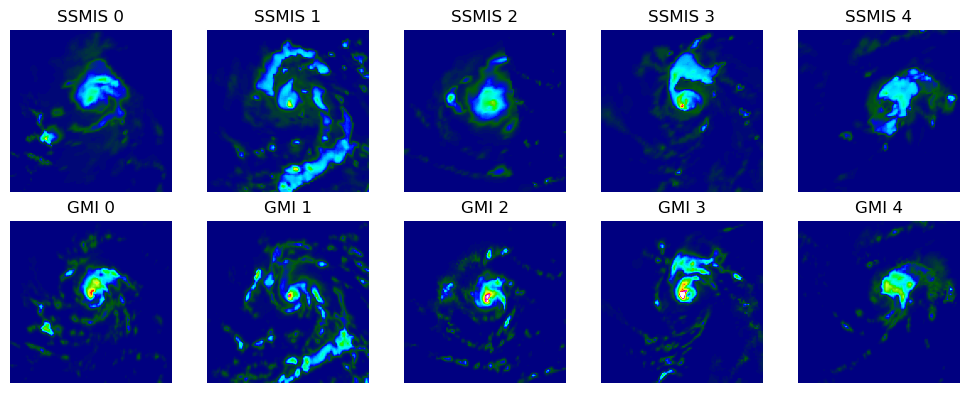

In [20]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Get a batch from the dataset
for train_batch, target_batch in dataset.take(1):  # Take one batch
    train_samples = train_batch.numpy()  # Convert to NumPy for visualization
    target_samples = target_batch.numpy()
    print("train_samples shape: ",     train_samples.shape, 
          " target_samples shape: ",   target_samples.shape)
    print("train_samples max: ", np.amax(train_samples), 
          "target_samples max: ", np.amax(target_samples))
    break  # Exit after one batch

# Number of samples to display
num_samples = min(5, train_samples.shape[0])  # Ensure we don't exceed batch size

# Plot the images
fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))

for i in range(num_samples):
    # Plot train_data image
    axes[0, i].imshow(train_samples[i].squeeze(), cmap='gist_ncar', vmin=0, vmax=.35)
    axes[0, i].set_title(f"SSMIS {i}")
    axes[0, i].axis("off")

    # Plot train_target image
    axes[1, i].imshow(target_samples[i].squeeze(), cmap='gist_ncar', vmin=0, vmax=.35)
    axes[1, i].set_title(f"GMI {i}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

epochs=450

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    
# Encoder
input_img = Input(shape=(96, 96, 1))
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
#x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
#x = MaxPooling2D((2, 2), padding="same")(x)

# Bottleneck
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

# Decoder
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

output_img = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Compile & Train
autoencoder = Model(input_img, output_img)
#autoencoder.compile(optimizer="adam", loss="mae") # not working for epochs=4
#autoencoder.compile(optimizer="adam", loss="mse") # not working for epochs=4
autoencoder.compile(optimizer="adam", loss=ssim_loss, metrics=['mse']) # works for epochs=4, 10, 100

history=autoencoder.fit(dataset, epochs=epochs)


Epoch 1/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.4484 - mse: 0.0617
Epoch 2/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1007 - mse: 4.2201e-04
Epoch 3/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0970 - mse: 3.8584e-04
Epoch 4/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0962 - mse: 3.7395e-04
Epoch 5/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0954 - mse: 3.6356e-04
Epoch 6/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0946 - mse: 3.4846e-04
Epoch 7/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0940 - mse: 3.3552e-04
Epoch 8/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0934 - mse: 3.2886e-04
Epoch 9/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0930 - mse: 3.1962e-04
Epoch 10/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0927 - mse: 3.1659e-04
Epoch 11/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0925 - mse: 3.1137e-04
Epoch 12/450
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 

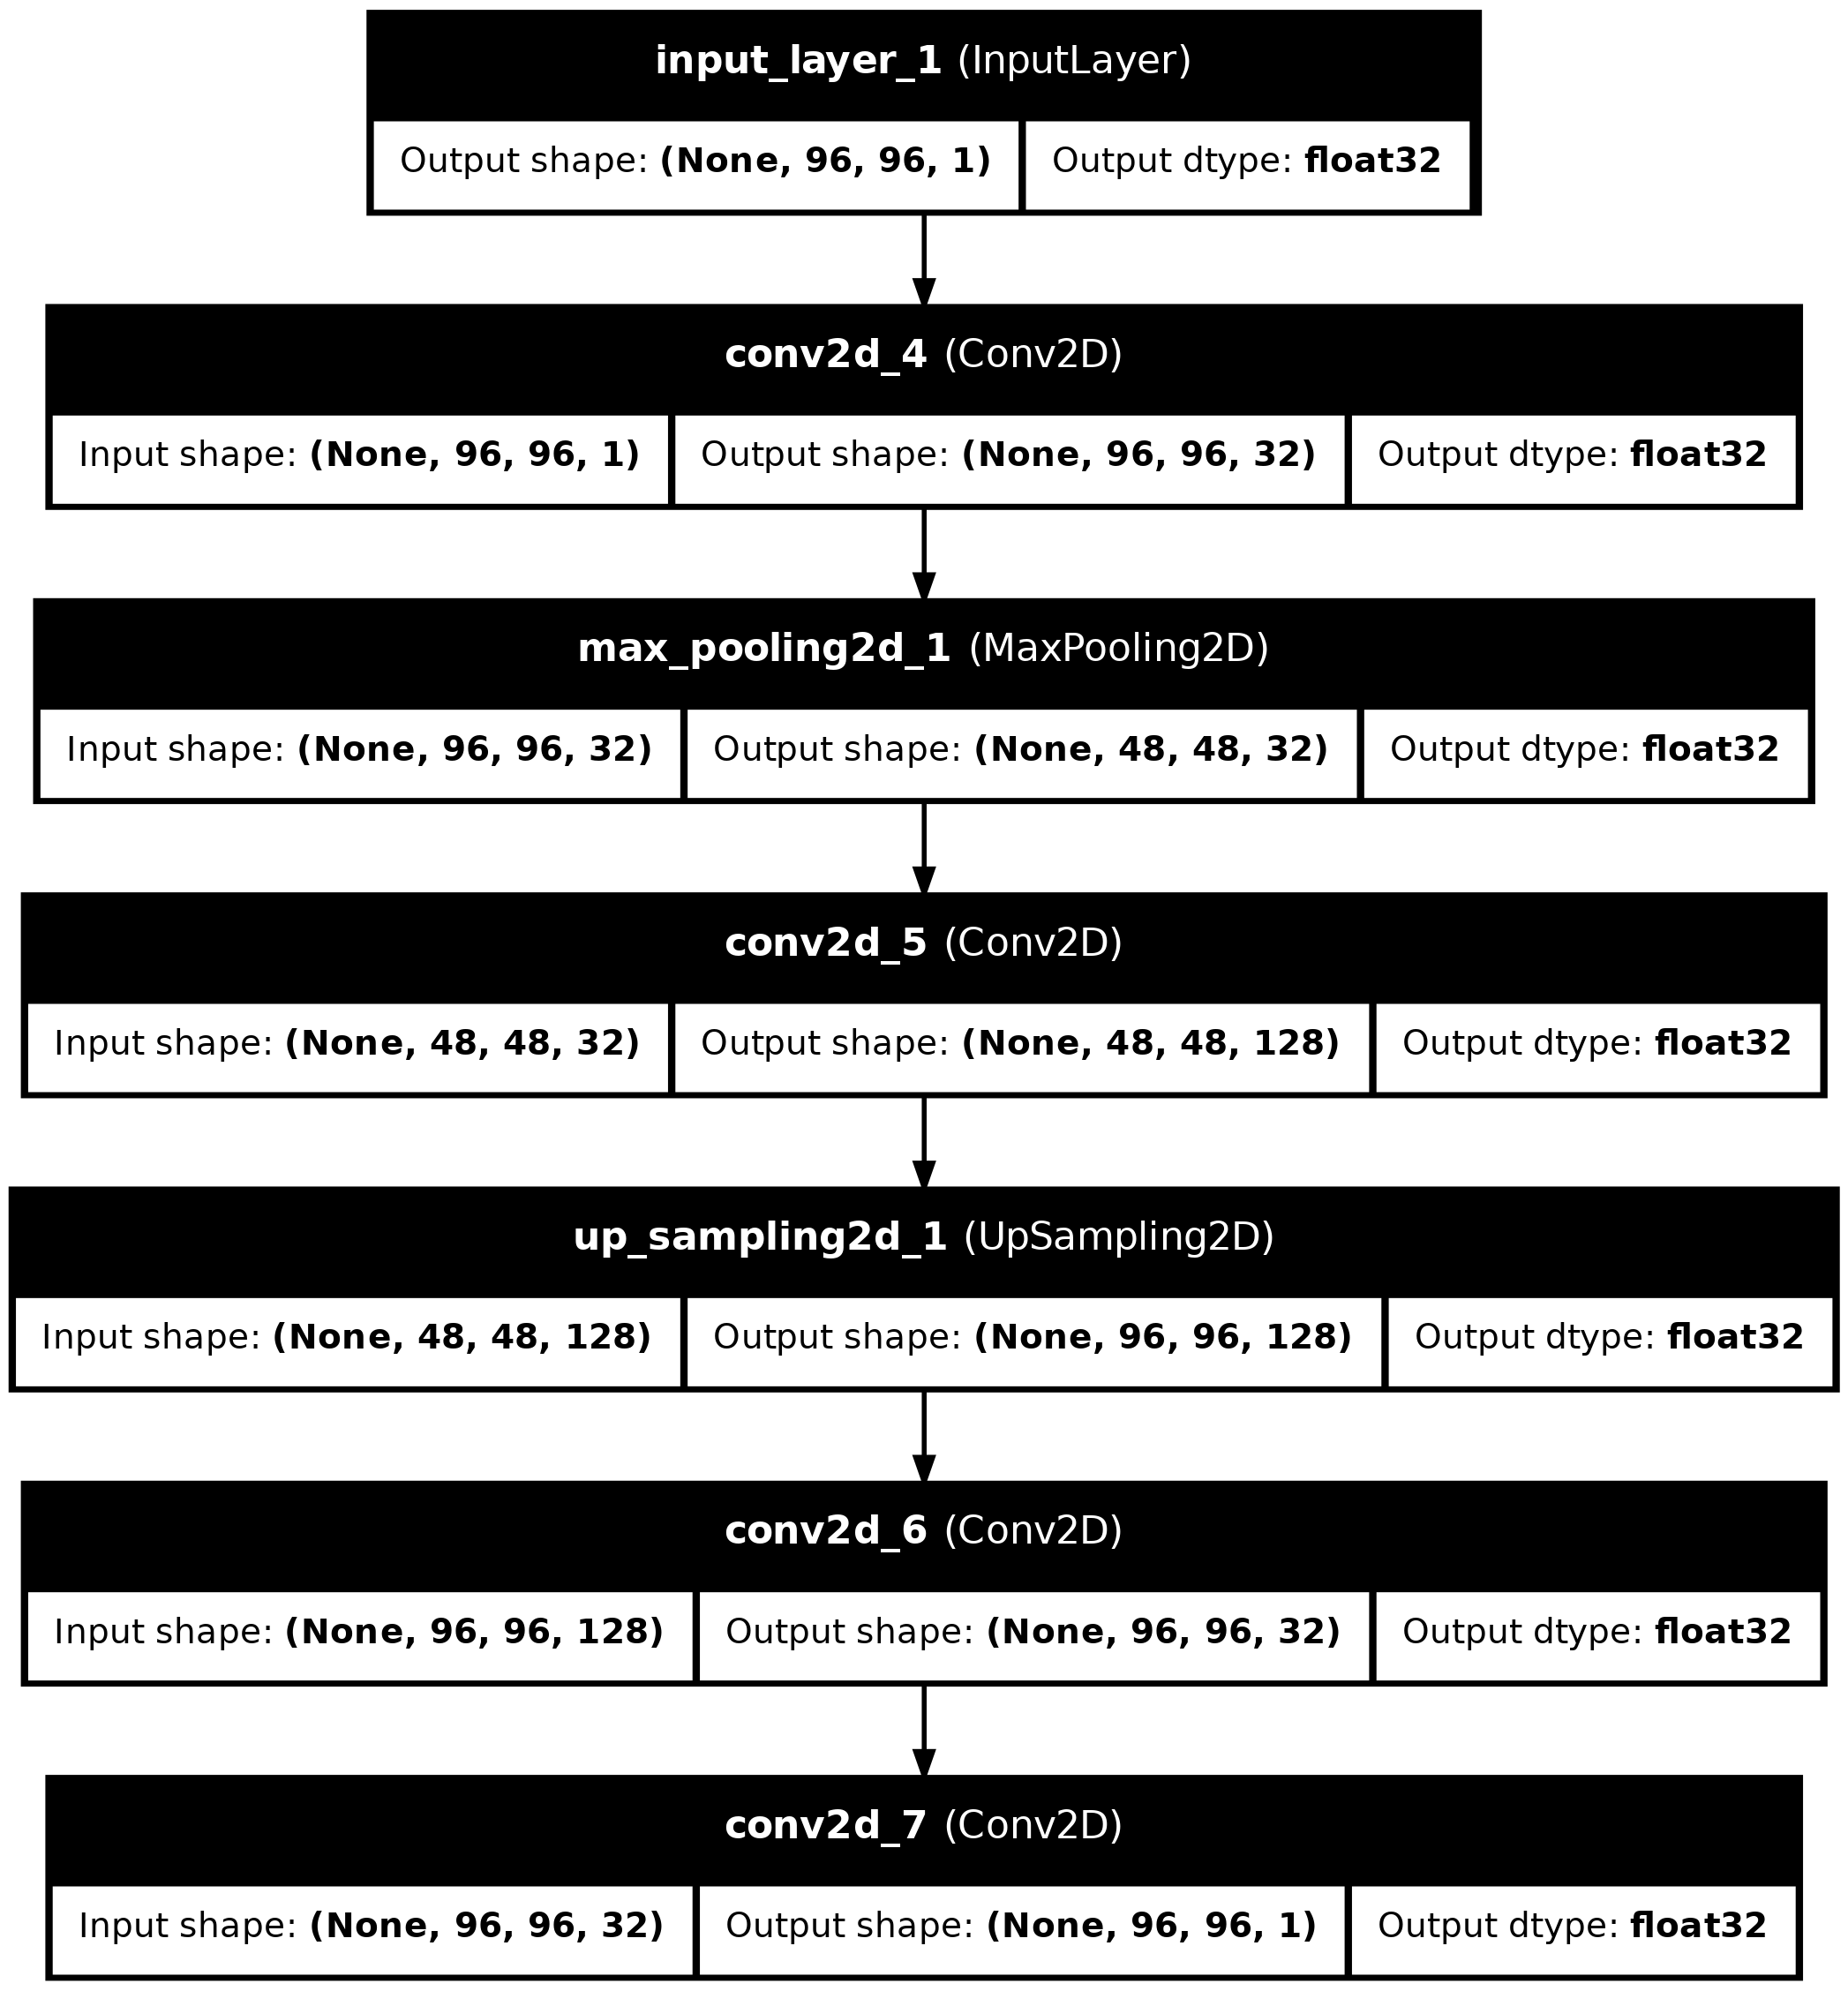

In [22]:
autoencoder.save('autoencoder_'+ str(epochs) + '_epochs.keras')
tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_dtype=True, show_layer_names=True)


In [23]:
history.history

{'loss': [0.22666391730308533,
  0.10071905702352524,
  0.0983579009771347,
  0.0973125547170639,
  0.0966191366314888,
  0.0960247591137886,
  0.09554167091846466,
  0.09508349001407623,
  0.09507041424512863,
  0.09465774148702621,
  0.09428729116916656,
  0.09403469413518906,
  0.09396925568580627,
  0.0938519611954689,
  0.09352264553308487,
  0.09345696866512299,
  0.09341203421354294,
  0.09361504018306732,
  0.0934484601020813,
  0.0934557318687439,
  0.09332682192325592,
  0.09323818236589432,
  0.09293655306100845,
  0.09291394054889679,
  0.0927446186542511,
  0.09240933507680893,
  0.09234693646430969,
  0.092147596180439,
  0.09190943092107773,
  0.09181875735521317,
  0.09163301438093185,
  0.09145032614469528,
  0.09132489562034607,
  0.0912686288356781,
  0.09111776947975159,
  0.09113065898418427,
  0.0908060222864151,
  0.09091401100158691,
  0.09071666747331619,
  0.09059847146272659,
  0.09045571088790894,
  0.09029397368431091,
  0.09033419191837311,
  0.09018848091

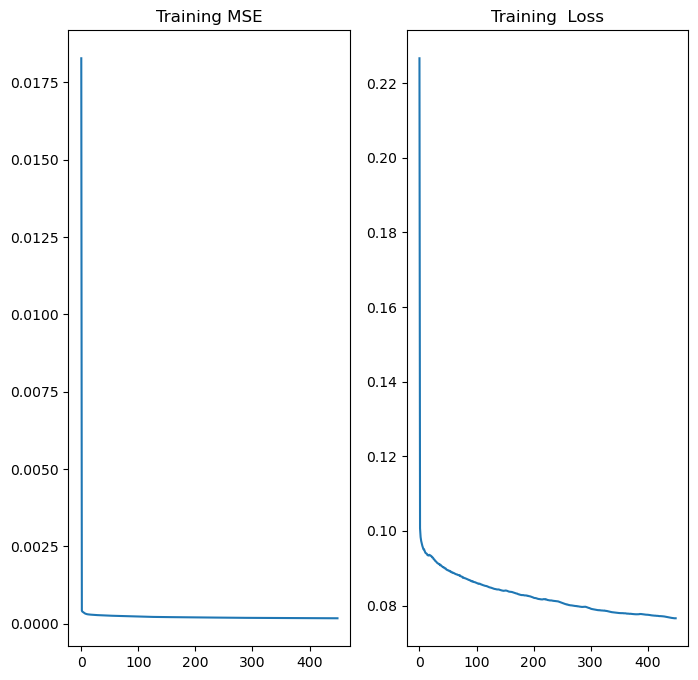

In [24]:
mse = history.history['mse']
#val_acc = history.history['val_mse']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mse, label='Training MSE')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
plt.title('Training MSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
plt.title('Training  Loss')
plt.show()


In [25]:
'''
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow.image as tf_image

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf_image.ssim(y_true, y_pred, max_val=1.0))
   
def build_autoencoder():
    input_img = layers.Input(shape=(96, 96, 1))  # Low-quality image

    # Encoder
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Bottleneck
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    # Decoder
    #x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x) # add one more
    #x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
    #x = layers.Conv2DTranspose(16, (3, 3), activation="relu", strides=1, padding="same")(x)
    output_img = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)  # High-quality output

    return models.Model(input_img, output_img)

# Build the model
autoencoder = build_autoencoder()
#autoencoder.compile(optimizer="adam", loss="mse")
#autoencoder.compile(optimizer="adam", loss="mae")
autoencoder.compile(optimizer="adam", loss=ssim_loss)

# Train the model
autoencoder.fit(dataset, epochs=4)
'''
# Test on a few images

predictions=np.empty([0, 96, 96, 1]) 
low_res=np.empty([0, 96, 96, 1]) 
high_res=np.empty([0, 96, 96, 1]) 

for low_res1, high_res1 in dataset.take(50):
    prediction = autoencoder.predict(low_res1)
    predictions=np.concatenate((predictions, prediction))
    low_res=np.concatenate((low_res, low_res1))
    high_res=np.concatenate((high_res, high_res1))
    
predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

2025-04-06 20:33:17.466084: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(800, 96, 96, 1)

In [26]:
type(low_res)


numpy.ndarray

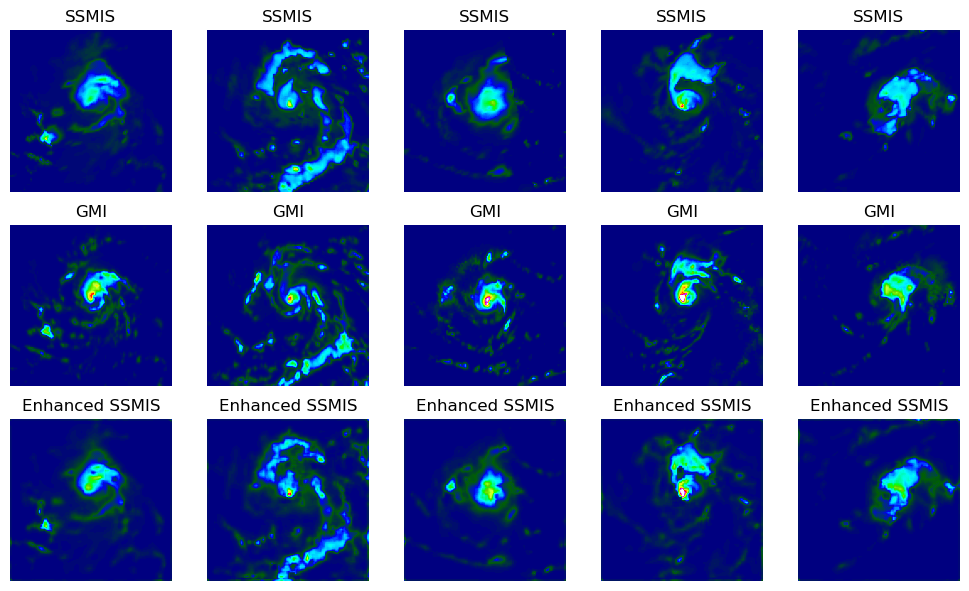

In [27]:
# Plot a few samples
num_samples = 5
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))

for i in range(num_samples):
    # Low-quality input
    axes[0, i].imshow(low_res[i].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[0, i].set_title("SSMIS")
    axes[0, i].axis("off")

    # Ground truth high-quality
    axes[1, i].imshow(high_res[i].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[1, i].set_title("GMI")
    axes[1, i].axis("off")

    # Model prediction
    axes[2, i].imshow(predictions[i].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[2, i].set_title("Enhanced SSMIS")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

In [28]:
predictions.shape

(800, 96, 96, 1)

In [29]:
print("max of predictions:", np.amax(predictions)*scale, " max of target: ", np.amax(high_res)*scale)

max of predictions: 143.65511012600928  max of target:  113.70800516949294


In [30]:
print("max of low_res: ", np.amax(low_res)*scale) 

max of low_res:  62.40749535005807


In [31]:
print ("min of predictions:", np.amin(predictions)*scale,  "min of target: ", np.amin(high_res)*scale)

min of predictions: 5.022742027082153e-05 min of target:  0.0


In [32]:
from scipy.stats import gaussian_kde
from sklearn.metrics import root_mean_squared_error

# Assuming prediction and high_res have shape (16, 96, 96, 1)
# Flatten them to 1D arrays
pred_flat = predictions.flatten()*scale
gt_flat = high_res.flatten()*scale 
lr_flat = low_res.flatten()*scale 

rms_hr = root_mean_squared_error(gt_flat, pred_flat)
rms_lr = root_mean_squared_error(gt_flat, lr_flat)

print("RMSE before: ", rms_lr, " RMSE after: ", rms_hr)

cor_hr=np.corrcoef(gt_flat, pred_flat)[0, 1]
cor_lr=np.corrcoef(gt_flat, lr_flat)[0, 1]
print("Corr before: ", cor_lr, " Corr after: ", cor_hr)

RMSE before:  2.472299402463726  RMSE after:  2.1598039962847295
Corr before:  0.7606253082633186  Corr after:  0.8199500837188027


/data1/tiany/anaconda3/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/data1/tiany/anaconda3/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


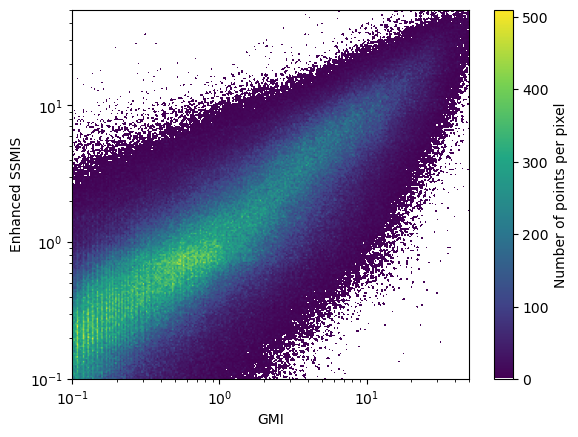

In [33]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Fake data for testing
x = gt_flat
y = pred_flat# Assume x and y are NumPy arrays of the same shape

mask = (x > 0.1) & (y > 0.1)

# Apply the mask
x1 = x[mask]
y1 = y[mask]


# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x1, y1):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x1, y1, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
    ax.set_xlim(0.1, 50)
    ax.set_ylim(0.1, 50)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GMI')
    ax.set_ylabel('Enhanced SSMIS')
 

fig = plt.figure()
using_mpl_scatter_density(fig, x1, y1)
plt.show()

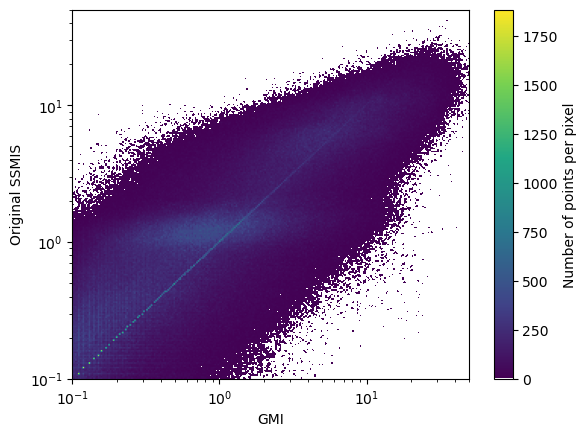

In [42]:
 
# Fake data for testing
x = gt_flat
y = lr_flat# Assume x and y are NumPy arrays of the same shape

mask = (x > 0.1) & (y > 0.1)

# Apply the mask
x1 = x[mask]
y1 = y[mask]


# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x1, y1):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x1, y1, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel') #, boundaries=np.array([0, 100, 200, 300, 400, 500]))
    ax.set_xlim(0.1, 50)
    ax.set_ylim(0.1, 50)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GMI')
    ax.set_ylabel('Original SSMIS')
 

fig = plt.figure()
using_mpl_scatter_density(fig, x1, y1)
plt.show()